# I. Set up

## dependencies

In [1]:
import numpy as np
import utils
import pickle
import scipy
from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split



%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



## Constants

In [2]:


# I pulled activations of 8 layers. Here is the index ref to the layers
LAYERS = {'pool1': 0, 'pool2': 1, 'pool3': 2, 'pool4': 3,
          'pool5': 4, 'fc6': 5, 'fc7': 6, 'prob': 7}

# constants for the images
NUM_VIEWS = 40
CARS = ['limo', 'suv', 'smart', 'sedan']
FURNITURES = ['bed', 'chair', 'table', 'bench']
OBJECTS = CARS + FURNITURES
# sample image url: https://s3.amazonaws.com/morphrecog-images-1/limoToSUV_10_10_99.png.png
# CARS_label = ['limoToSUV_10','limoToSUV_99','smartToSedan_10','smartToSedan_99'];
# FIURNITURES_label = ['bedChair_1', 'bedChair_100', 'tableBench_1', 'tableBench_100']

 

# constants for train/test for the linear discriminability
TRAIN_SZ = 0.80
TEST_SZ = 1 - TRAIN_SZ




## pulling and cleaning up the data 

In [3]:
# downloading the activations. I had to split the sample (each act has 160 images) because they're about 3GB each. 
act1 = pickle.load(open('activations.p', 'rb'))
act2 = pickle.load(open('activations2.p', 'rb'))

In [4]:
# pulling out all the fc6, fc7 layers for all images to have a smaller set to work with. 
fc6 = np.vstack((np.asarray(act1[LAYERS['fc6']]), np.asarray(act2[LAYERS['fc6']])))
fc7 = np.vstack((np.asarray(act1[LAYERS['fc7']]), np.asarray(act2[LAYERS['fc7']])))


In [5]:
# pulling out remaining pooling layers
pool = [] 

for i in xrange(0,5):
    pool1_i, pool2_i = np.asarray(act1[i]), np.asarray(act2[i])

    pool_i = np.vstack((pool1_i.reshape(pool1_i.shape[0], pool1_i.shape[1] * pool1_i.shape[2] * pool1_i.shape[3]), 
                     pool2_i.reshape(pool2_i.shape[0], pool2_i.shape[1] * pool2_i.shape[2] * pool2_i.shape[3])))
    pool.append(pool_i)

# checking that i'm pulling the arrays correctly.... 
# using pool5 because it's the smallest. 
# pool[4][20][10:50]
# foo = act1[4][20].flatten()
# foo[10:50]

# II. Representational Similarity Analysis

In [6]:
# getMeanVector gets the mean vector across number of views for num_objects 
def getMeanVector(full_batch, num_views, num_objects):
    meanVector = np.empty((num_objects, full_batch.shape[1]), float)
    for i in xrange(0, num_objects):
        # pull out the views of the particular object 
        all_views = full_batch[i * num_views: (i + 1) * num_views, :]
        meanVector[i] = np.mean(all_views, axis = 0)

    
    return meanVector
# might need to normalize when takigng mean vector 

['limo', 'suv', 'smart', 'sedan', 'bed', 'chair', 'table', 'bench']


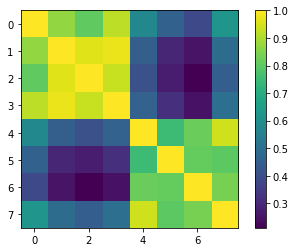

In [7]:
RDM_fc7 = np.corrcoef(getMeanVector(fc7, NUM_VIEWS, len(OBJECTS))) 
imgplot = plt.imshow(RDM_fc7)
#plt.axis(['limo', 'SUV', 'smart car', 'sedan', 'bed', 'chair', 'bench', 'bed'])
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.colorbar();
print CARS + FURNITURES

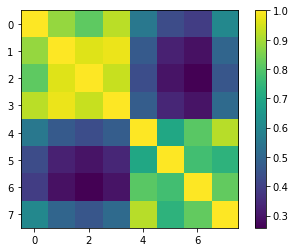

In [8]:
RDM_fc6 = np.corrcoef(getMeanVector(fc6, NUM_VIEWS, len(OBJECTS))) 
imgplot = plt.imshow(RDM_fc6)
plt.colorbar();

In [9]:
print "If the fc6 and fc7 RDM look similar, they are-- note:"
print "Taking the difference between fc6 and fc7, we have: "  + str((fc6 - fc7).max())
print "Taking the difference between RDM of fc6 and fc7, we have: " + str((RDM_fc6 - RDM_fc7).max())

If the fc6 and fc7 RDM look similar, they are-- note:
Taking the difference between fc6 and fc7, we have: 32.3581
Taking the difference between RDM of fc6 and fc7, we have: 0.0470156385361


In [10]:
# code for debugging my RDM_within/between
# def getRDM_mean(rdm):
if True:
    rdm = np.arange(1,65).reshape(8,8)
    print "this is original"
    print rdm
    # get upper triangle without diagnoal 
    rdm_all = np.triu(rdm, 1) 
    
    print "this should be the upper right triangle" 
    print rdm_all
    
    # upper right block is the between car/furniture category  
    rdm_between = rdm_all[:-4, 4:]
    print "this should be between, the upper right block"
    print rdm_between
    mean_between = rdm_between.flatten().sum()/16
    
    
    # everything else is within categories 
    rdm_within = rdm_all
    rdm_within[:-4, 4:] = 0
    print "this should be within; the diagonal entries" 
    print rdm_within
    mean_within = rdm_all.flatten().sum()/12

#    return (mean_within, mean_between, abs(mean_within - mean_between))
        
    
    

this is original
[[ 1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16]
 [17 18 19 20 21 22 23 24]
 [25 26 27 28 29 30 31 32]
 [33 34 35 36 37 38 39 40]
 [41 42 43 44 45 46 47 48]
 [49 50 51 52 53 54 55 56]
 [57 58 59 60 61 62 63 64]]
this should be the upper right triangle
[[ 0  2  3  4  5  6  7  8]
 [ 0  0 11 12 13 14 15 16]
 [ 0  0  0 20 21 22 23 24]
 [ 0  0  0  0 29 30 31 32]
 [ 0  0  0  0  0 38 39 40]
 [ 0  0  0  0  0  0 47 48]
 [ 0  0  0  0  0  0  0 56]
 [ 0  0  0  0  0  0  0  0]]
this should be between, the upper right block
[[ 5  6  7  8]
 [13 14 15 16]
 [21 22 23 24]
 [29 30 31 32]]
this should be within; the diagonal entries
[[ 0  2  3  4  0  0  0  0]
 [ 0  0 11 12  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 38 39 40]
 [ 0  0  0  0  0  0 47 48]
 [ 0  0  0  0  0  0  0 56]
 [ 0  0  0  0  0  0  0  0]]


In [11]:
# def getRDM_mean_full(rdm, num_objects, num_views):
if True:
    num_objects = len(OBJECTS)
    num_views = 4
    rdm = np.arange(1,1025).reshape(32,32)
    print "this is original"
    print rdm
    # get upper triangle without diagnoal 
    rdm_all = np.triu(rdm, 1)    
    print "this should be the upper right triangle" 
    print rdm_all
    
    # just get within category for now-- take the furniture category for now. 
    rdm_furniture = rdm_all[-16:, -16:]
    print "this should be the lower right"
    print rdm_furniture
    
     
    # then we get all the diagonal matrix elements
    within_object_i = np.arange(16)
    print "now we want to take the daigonal matrix elements"
    within_object_sum = 0
    for i in xrange(0,num_objects/2):
        ind_start = i * (num_views )
        ind_end = (i + 1) * (num_views) 
        print rdm_furniture[ind_start:ind_end, ind_start:ind_end]
        within_object_sum += np.sum(rdm_furniture[ind_start:ind_end, ind_start:ind_end].flatten())
    
    within_object_mean = within_object_sum/ (6 * num_objects/2)
    
    
    # then we get mean cross object, within the same category
    rdm_across_obj_furniture = rdm_furniture
    for i in xrange(0,num_objects/2):
        ind_start = i * (num_views)
        ind_end = (i + 1) * (num_views) 
    
        rdm_across_obj_furniture[ind_start:ind_end, ind_start:ind_end] = 0 
    print "now we want the rest"
    print rdm_across_obj_furniture
    mean_within = rdm_all.flatten().sum()/96

#    return (mean_within, mean_between, abs(mean_within - mean_between))
        

this is original
[[   1    2    3 ...,   30   31   32]
 [  33   34   35 ...,   62   63   64]
 [  65   66   67 ...,   94   95   96]
 ..., 
 [ 929  930  931 ...,  958  959  960]
 [ 961  962  963 ...,  990  991  992]
 [ 993  994  995 ..., 1022 1023 1024]]
this should be the upper right triangle
[[  0   2   3 ...,  30  31  32]
 [  0   0  35 ...,  62  63  64]
 [  0   0   0 ...,  94  95  96]
 ..., 
 [  0   0   0 ...,   0 959 960]
 [  0   0   0 ...,   0   0 992]
 [  0   0   0 ...,   0   0   0]]
this should be the lower right
[[  0 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544]
 [  0   0 563 564 565 566 567 568 569 570 571 572 573 574 575 576]
 [  0   0   0 596 597 598 599 600 601 602 603 604 605 606 607 608]
 [  0   0   0   0 629 630 631 632 633 634 635 636 637 638 639 640]
 [  0   0   0   0   0 662 663 664 665 666 667 668 669 670 671 672]
 [  0   0   0   0   0   0 695 696 697 698 699 700 701 702 703 704]
 [  0   0   0   0   0   0   0 728 729 730 731 732 733 734 735 736]
 [  0  

In [12]:
def getRDM_mean_furn(rdm, num_objects, num_views):

    # get upper triangle without diagnoal 
    rdm_all = np.triu(rdm, 1)    

    
    # just get within category for now-- take the furniture category for now. 
    rdm_furniture = rdm_all[-160:, -160:]

    
     
    # then we get all the diagonal matrix elements
    within_object_i = np.arange(160)
    within_object_sum = 0
    for i in xrange(0,num_objects):
        ind_start = i * (num_views)
        ind_end = (i + 1) * (num_views) 
        within_object_sum += np.sum(rdm_furniture[ind_start:ind_end, ind_start:ind_end].flatten())
    
    mean_within_object_furniture = within_object_sum/ ((num_views * num_views)/2 - num_views/2 * num_objects)
    
    
    # then we get mean cross object, within the same category
    rdm_across_obj_furniture = rdm_furniture
    for i in xrange(0,num_objects):
        ind_start = i * (num_views)
        ind_end = (i + 1) * (num_views) 
        
        rdm_across_obj_furniture[ind_start:ind_end, ind_start:ind_end] = 0 

    mean_across_obj_furniture = (rdm_across_obj_furniture.flatten().sum())/960

    return (mean_within_object_furniture, mean_across_obj_furniture, abs(mean_within_object_furniture -mean_across_obj_furniture))



IndentationError: unexpected indent (<ipython-input-12-f72c78cb56da>, line 4)

In [14]:
# code from stack exchange (https://goo.gl/MRHFQw) 
# Extracts blocks of size M from the kth diagonal
# of square matrix A, whose size must be a multiple of n.
def extract_block_diag(a, n, k=0):

    a = np.asarray(a)
    if a.ndim != 2:
        raise ValueError("Only 2-D arrays handled")
    if not (n > 0):
        raise ValueError("Must have n >= 0")

    if k > 0:
        a = a[:,n*k:] 
    else:
        a = a[-n*k:]

    n_blocks = min(a.shape[0]//n, a.shape[1]//n)

    new_shape = (n_blocks, n, n)
    new_strides = (n*a.strides[0] + n*a.strides[1],
                   a.strides[0], a.strides[1])

    return np.lib.stride_tricks.as_strided(a, new_shape, new_strides)



# III. Linear Discriminability

In [ ]:

# full_batch: the full batch of images. I am assuming that the full_batch is arranged as 40 views of obj1, 40 objects of obj2... so forth.  
# train_sz: needs to be a probability, s.t. test_sz = 1 - train-sz. 
def getData(full_batch, num_views, num_objects, test_sz):
    
    num_train = int(num_views * (1 - test_sz))
    num_test = num_views - num_train
    
    X_train = np.ones((num_train * num_objects, full_batch.shape[1]), float)
    X_test = np.ones((num_test * num_objects, full_batch.shape[1]), float)
    
    for i in xrange(0, num_objects):
        X = full_batch[i * num_views: (i + 1) * num_views, :]
        
        # randomly shuffle the train/test for the x 
        X_train_i, X_test_i = train_test_split(X, test_size=test_sz)
        X_train[i * num_train: (i + 1) * num_train, :] = X_train_i
        X_test[i * num_test: (i + 1) * num_test, :] = X_test_i
        
        

    y_train = np.repeat(xrange(0, num_objects), num_train)
    y_test = np.repeat(xrange(0, num_objects), num_test)

    return (X_train, y_train, X_test, y_test)

# mini-test for the fnc 
# X_train, y_train, X_test, y_test = getData(fc6, NUM_VIEWS, len(OBJECTS), TEST_SZ)
# print "here is the full thing" 
# print np.sort(fc6[0:40,1])
# print "X_train"
# print np.sort(X_train[0:32,1])
# print "X_test"
# print np.sort(X_test[0:8, 1])


In [ ]:
logreg = linear_model.LogisticRegression()
X_train, y_train, X_test, y_test = getData(fc6, NUM_VIEWS, len(OBJECTS), TEST_SZ)
# for sanity check: X_test_r = np.random.rand(X_test.shape[0], X_test.shape[1])
print('LogisticRegression score: %f'
      % logreg.fit(X_test, y_test).score(X_train, y_train))

In [ ]:
logreg = linear_model.LogisticRegression()
X_train, y_train, X_test, y_test = getData(fc7, NUM_VIEWS, len(OBJECTS), TEST_SZ)
# for sanity check: X_test_r = np.random.rand(X_test.shape[0], X_test.shape[1])
print('LogisticRegression score: %f'
      % logreg.fit(X_test, y_test).score(X_train, y_train))

In [ ]:
# grab 5000 random features
np.random.seed(0)
x = np.arange(np.shape(pool[0])[1])
np.random.shuffle(x)
random5000 = x[:5000]
_pool0 = pool[0][:,random5000]

# compute 3-fold cross-validated accuracy 
from sklearn.model_selection import cross_val_score
X = _pool0
y = np.repeat(OBJECTS,40)
logreg = linear_model.LogisticRegression()
y_score = cross_val_score(logreg, X, y)
print y_score